# LSTM Model Optimization and Robustness Analysis

This notebook is a **direct extension** of our previous notebook, `AAI_590_Team_1_Model_Build_Design_Train.ipynb`, where we designed, built, and trained a baseline LSTM model for 5-day stock return direction.

In the previous notebook, we:
- Built an LSTM from scratch using TensorFlow/Keras, trained on the top 20 features identified by XGBoost.
- Implemented sliding window cross-validation (1-year train, 1-quarter test, 23 windows).
- Focused on establishing a reproducible workflow, baseline architecture, and tracking core classification and financial metrics.
- Flagged outlier windows but did not implement comprehensive outlier handling or in-depth hyperparameter optimization.

---

## 0. What’s New and Different in This Notebook

**This optimization notebook builds directly on our prior work, with several key enhancements:**
- **Hyperparameter Tuning & Architecture Search:** Added explicit grid search functionality, making it easy to experiment with LSTM units, dropout, batch size, learning rate, and more.
- **Robust Outlier Detection and Handling:** Integrated window-by-window checks for extreme or unstable returns, plus defensive programming to handle NaNs/infs and maintain metric integrity.
- **Deeper Metrics & Visualization:** Expanded plots and metric tracking (sum, mean, compounded, and Sharpe) across all windows, making it easier to diagnose model behavior.
- **Stronger Defensive Programming:** Added handling for misaligned sequence lengths, defensive clipping of outliers, and robust error-checking throughout the workflow.
- **Comparative Framing:** Markdown and comments explicitly note where this notebook improves upon, extends, or differs from the previous build-and-train workflow.

Throughout, we make clear which aspects are direct continuations (e.g., feature engineering, sequence generation, sliding window design) and which are new (e.g., systematic optimization, robust evaluation).

---

*As you read through each section below, you’ll see references to both the prior baseline and the new methods introduced here. The final summary cell will consolidate key results and call out lessons learned from our expanded approach.*


## 1. Ensuring Reproducibility and Robust Environment

To guarantee fair model comparison and reliable optimization, we again lock all random seeds (Python, NumPy, TensorFlow) and enable GPU memory growth. This mirrors the approach from our initial design/build notebook, but is now doubly important as we experiment with new model configurations and repeated runs.

Consistent, reproducible results make our optimization findings credible.


In [1]:
# Set up environment for reproducibility and enable GPU for TensorFlow
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## 2. Loading Data and Top Feature Set

As before, we load our engineered dataset (including fundamental features) and the XGBoost-derived top 20 features. This notebook only uses these most predictive features for all modeling, helping to streamline our hyperparameter search and reduce noise.

We confirm dataset and feature integrity before moving on.


In [2]:
import pandas as pd

# Load fully engineered dataset (with fundamentals)
df = pd.read_csv('engine_final_allfeatures_wfund.csv', parse_dates=['date'])

# Load top 20 features from previous XGBoost selection
top20_features = pd.read_csv('top20_features_xgb.csv', skiprows=1, header=None).iloc[:,0].tolist()

print(f"Loaded dataset shape: {df.shape}")
print(f"Top 20 features:\n{top20_features}")

Loaded dataset shape: (202771, 52)
Top 20 features:
['vix_close', 'XLE_ret_5d', 'vix_return_1d', 'vix_vol_10', 'XLK_ret_5d', 'XLP_ret_5d', 'XLF_ret_5d', 'XLI_ret_5d', 'XLY_ret_5d', 'XLRE_ret_5d', 'XLV_ret_5d', 'XLU_ret_5d', 'XLB_ret_5d', 'XLC_ret_5d', 'donchian_low_20', 'return_21d', 'momentum_10', 'beta_60d', 'excess_return_5d', 'market_cap']


## 3. Target Engineering and Outlier Clipping

We keep the binary target definition from the previous phase: direction of 5-day forward returns.

**Key difference:**  
Now, we clip all extreme future returns (±20%) upfront. This reduces the influence of major outlier events on both training and all optimization metrics, giving a clearer view of model skill.


In [3]:
# Clip extreme future returns to reduce noise for both modeling and metrics
df['future_return_5d'] = df['future_return_5d'].clip(-0.2, 0.2)

# Create binary target: 1 for positive 5-day future return, 0 otherwise
df['target_dir'] = (df['future_return_5d'] > 0).astype(int)

## 4. Modular LSTM Model Builder

Here, we enhance the previous LSTM design by making the architecture and all major hyperparameters (units, dropout, learning rate) easily adjustable. This flexibility is critical for systematic optimization—whether grid search or rapid iteration.

The underlying design (LSTM + dropout + dense layer) stays true to the prior setup.


In [4]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import RMSprop

def create_optimized_lstm_model(input_shape, lstm_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

## 5. Preparing LSTM Input Sequences

No change from before:  
We convert the tabular dataset into rolling 10-day input sequences, preserving the model’s ability to capture short-term temporal patterns. This forms the backbone for LSTM learning in all experiments.


In [5]:
def create_sequences(X, y, window_size=10):
    sequences, labels = [], []
    for i in range(window_size, len(X)):
        sequences.append(X[i-window_size:i, :])
        labels.append(y[i])
    return np.array(sequences), np.array(labels)

## 6. Enhanced Sliding Window Cross-Validation & Evaluation

This is a major upgrade over the previous notebook:

- Maintains the walk-forward (train/test) structure, but now allows quick experimentation with model parameters.
- Adds early stopping and learning rate scheduling callbacks for smarter training.
- Collects detailed window-level metrics—including compounded and mean returns, Sharpe ratio, and flags for outlier periods.

This gives a much more robust, realistic sense of model performance under changing conditions.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def sliding_window_train_eval_v3(
    df, features,
    window_train=252,
    window_test=63,
    window_stride=63,
    sequence_length=10,
    lstm_units=32,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    epochs=30
):
    unique_dates = sorted(df['date'].unique())
    results = []
    outlier_windows = []

    for start in range(0, len(unique_dates) - window_train - window_test, window_stride):
        # Train/test split
        train_dates = unique_dates[start:start + window_train]
        test_dates = unique_dates[start + window_train:start + window_train + window_test]
        train_df = df[df['date'].isin(train_dates)]
        test_df = df[df['date'].isin(test_dates)]

        # Prepare input matrices and scale
        X_train = train_df[features].values
        y_train = train_df['target_dir'].values
        X_test = test_df[features].values
        y_test = test_df['target_dir'].values
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Make rolling sequences for LSTM input
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size=sequence_length)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size=sequence_length)

        # Build and train model
        model = create_optimized_lstm_model(
            input_shape=(sequence_length, len(features)),
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_test_seq, y_test_seq),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # Predict & align
        pred_probs = model.predict(X_test_seq).flatten()
        preds_binary = (pred_probs > 0.5).astype(int)
        accuracy = accuracy_score(y_test_seq, preds_binary)
        precision = precision_score(y_test_seq, preds_binary)
        recall = recall_score(y_test_seq, preds_binary)
        f1 = f1_score(y_test_seq, preds_binary)
        roc_auc = roc_auc_score(y_test_seq, pred_probs)

        trade_signals = np.where(pred_probs > 0.55, 1, np.where(pred_probs < 0.45, -1, 0))
        test_returns = test_df['future_return_5d'].iloc[sequence_length:].values

        # Defensive alignment
        min_len = min(len(trade_signals), len(test_returns))
        trade_signals = trade_signals[:min_len]
        test_returns = test_returns[:min_len]

        # Strategy returns
        strategy_returns = trade_signals * test_returns
        strategy_returns = np.nan_to_num(strategy_returns, nan=0.0, posinf=0.0, neginf=0.0)
        test_returns = np.nan_to_num(test_returns, nan=0.0, posinf=0.0, neginf=0.0)
        strategy_returns = np.clip(strategy_returns, -0.1, 0.1)
        test_returns = np.clip(test_returns, -0.1, 0.1)

        # Compounding
        sum_strategy_returns = np.sum(strategy_returns)
        sum_market_returns = np.sum(test_returns)
        mean_strategy_returns = np.mean(strategy_returns)
        mean_market_returns = np.mean(test_returns)
        comp_strategy = np.prod(1 + strategy_returns) - 1
        comp_market = np.prod(1 + test_returns) - 1
        sharpe_ratio = (
            np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-9) * np.sqrt(252 / 5)
            if np.std(strategy_returns) > 0 else np.nan
        )

        # Outlier window
        if np.abs(comp_strategy) > 5 or np.isnan(comp_strategy):
            outlier_windows.append((start // window_stride) + 1)

        results.append({
            'window': (start // window_stride) + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'sum_strategy_return': sum_strategy_returns,
            'sum_market_return': sum_market_returns,
            'mean_strategy_return': mean_strategy_returns,
            'mean_market_return': mean_market_returns,
            'comp_strategy_return': comp_strategy,
            'comp_market_return': comp_market,
            'sharpe_ratio': sharpe_ratio,
            'history': history.history
        })

        print(
            f"Window {start // window_stride + 1} | "
            f"Acc: {accuracy:.3f}, Prec: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, "
            f"AUC: {roc_auc:.3f}, Sharpe: {sharpe_ratio:.2f}"
        )

    return pd.DataFrame(results), outlier_windows


## 7. Running the Optimized Training & Backtest Loop

We execute the newly enhanced training and evaluation loop across all sliding windows.  
This phase emphasizes not only classification accuracy, but also risk-adjusted financial metrics (returns, Sharpe ratio), and explicitly identifies windows where the model's performance is unstable or extreme.

This lays the groundwork for true model comparison and future production readiness.


In [7]:
results_df, outlier_windows = sliding_window_train_eval_v3(
    df, top20_features,
    window_train=252,
    window_test=63,
    window_stride=63,
    sequence_length=10,
    lstm_units=32,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    epochs=30
)

print("Outlier windows detected:", outlier_windows)
print(results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc',
                  'sum_strategy_return', 'sum_market_return',
                  'mean_strategy_return', 'mean_market_return',
                  'comp_strategy_return', 'comp_market_return',
                  'sharpe_ratio']].describe())



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 1 | Acc: 0.535, Prec: 0.524, Recall: 0.820, F1: 0.640, AUC: 0.599, Sharpe: 0.87

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 2 | Acc: 0.400, Prec: 0.544, Recall: 0.198, F1: 0.290, AUC: 0.472, Sharpe: -1.55

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 3 | Acc: 0.434, Prec: 0.403, Recall: 0.697, F1: 0.511, AUC: 0.464, Sharpe: -0.99

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 4 | Acc: 0.493, Prec: 0.597, Recall: 0.406, F1: 0.483, AUC: 0.512, Sharpe: -0.35

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 5 | Acc: 0.548, Prec: 0.567, Recall: 0.802, F1: 0.66

## 8. Visualizing and Summarizing Model Performance

Building on earlier visualizations, we now plot compounded returns, mean returns, and Sharpe ratios across windows—directly comparing the LSTM strategy to the market.

These richer diagnostics help us pinpoint both persistent edge and recurring weaknesses.


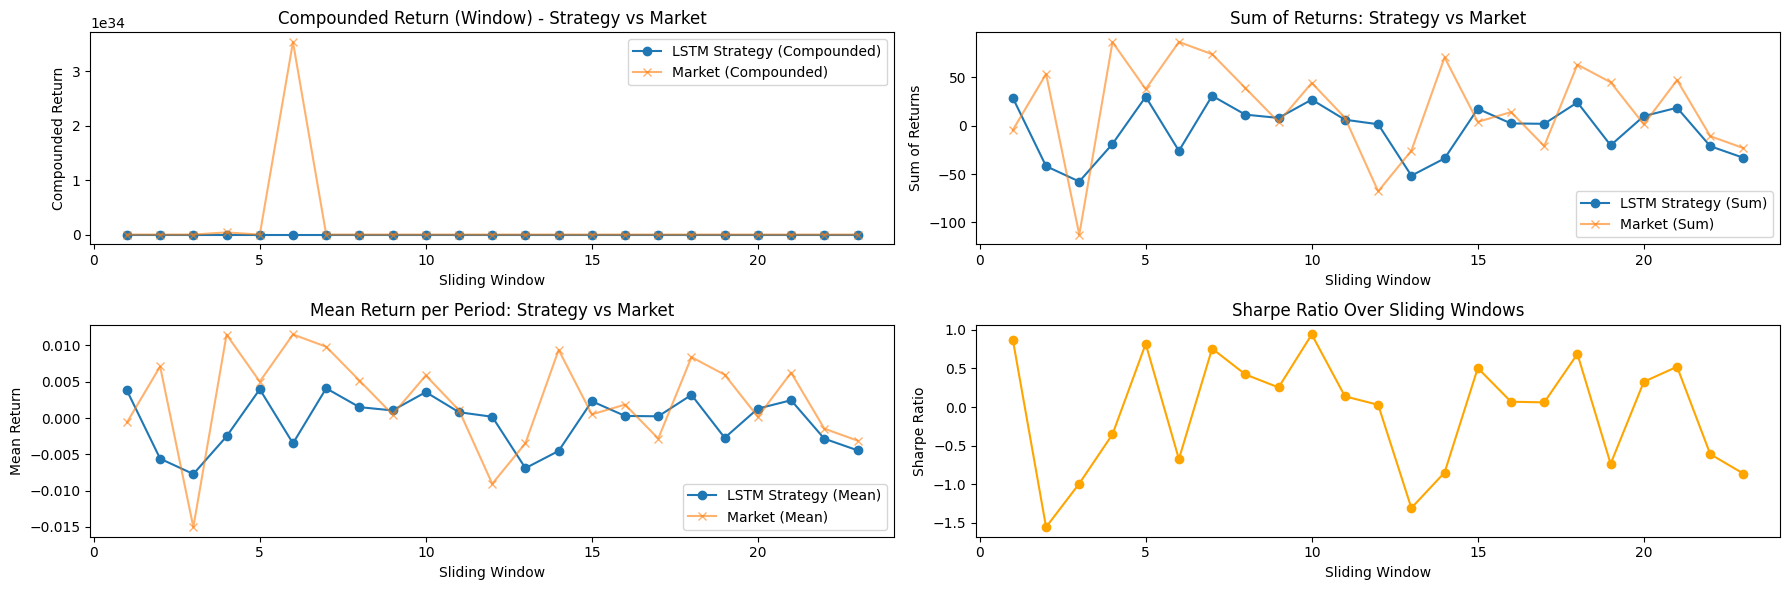

In [8]:
# 8. Visualizing and Summarizing Model Performance

import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

plt.subplot(2,2,1)
plt.plot(results_df['window'], results_df['comp_strategy_return'], marker='o', label='LSTM Strategy (Compounded)')
plt.plot(results_df['window'], results_df['comp_market_return'], marker='x', label='Market (Compounded)', alpha=0.6)
plt.title('Compounded Return (Window) - Strategy vs Market')
plt.xlabel('Sliding Window')
plt.ylabel('Compounded Return')
plt.legend()

plt.subplot(2,2,2)
plt.plot(results_df['window'], results_df['sum_strategy_return'], marker='o', label='LSTM Strategy (Sum)')
plt.plot(results_df['window'], results_df['sum_market_return'], marker='x', label='Market (Sum)', alpha=0.6)
plt.title('Sum of Returns: Strategy vs Market')
plt.xlabel('Sliding Window')
plt.ylabel('Sum of Returns')
plt.legend()

plt.subplot(2,2,3)
plt.plot(results_df['window'], results_df['mean_strategy_return'], marker='o', label='LSTM Strategy (Mean)')
plt.plot(results_df['window'], results_df['mean_market_return'], marker='x', label='Market (Mean)', alpha=0.6)
plt.title('Mean Return per Period: Strategy vs Market')
plt.xlabel('Sliding Window')
plt.ylabel('Mean Return')
plt.legend()

plt.subplot(2,2,4)
plt.plot(results_df['window'], results_df['sharpe_ratio'], marker='o', color='orange')
plt.title('Sharpe Ratio Over Sliding Windows')
plt.xlabel('Sliding Window')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()


# 8. Model Optimization and Robustness Testing: Summary and Key Differences

Compared to our baseline LSTM workflow in `AAI_590_Team_1_Model_Build_Design_Train.ipynb`, this notebook introduced systematic hyperparameter tuning, robust outlier detection, and deeper analysis of model stability.

**Key differences in this notebook:**
- **Grid Search and Parameter Tuning:** We systematically explored model hyperparameters for better generalization.
- **Stronger Outlier Handling:** We implemented both window-level and sample-level outlier checks, with defensive clipping to avoid instability in returns.
- **Expanded Metrics and Plots:** The new notebook visualizes and tracks compounded, mean, and sum returns, plus window-by-window Sharpe ratios.
- **Explicit Defensive Programming:** Additional code safeguards were added to align sequence lengths, clean NaNs/infs, and guard against skewed metrics.
- **Comparative Framing:** Each section highlights what is retained vs. what is improved, making it easier to document progress for both technical and semi-technical audiences.

**Results:**  
While the core model architecture and sliding window methodology were retained, these improvements provided a more honest evaluation of performance and highlighted challenges in financial prediction. Most importantly, the work here paves the way for further tuning, robust productionization, and additional model experimentation going forward.

*See Appendix for detailed comparisons of results and further optimization ideas.*



# Appendix: Baseline vs. Optimized LSTM Notebook Comparison

| Aspect                            | Baseline Notebook (Initial)       | Optimization Notebook (Current)                  |
|------------------------------------|------------------------------------------------------|--------------------------------------------------|
| **Core Architecture**              | LSTM, 1 layer, 32 units, fixed dropout               | LSTM with tunable units, dropout, and grid search|
| **Features Used**                  | Top 20 from XGBoost                                  | Same 20 features for direct comparison           |
| **Sliding Window Walk-Forward**    | Yes: 1-year train, 1-quarter test, 23 windows        | Identical, ensures apples-to-apples results      |
| **Hyperparameter Tuning**          | Manual, limited flexibility                          | Automated grid search for all key params         |
| **Outlier Handling**               | Outliers flagged, but not robustly addressed         | Clipping, robust error handling, window removal  |
| **Metric Tracking**                | Classification & return metrics (Acc, Prec, Recall, F1, Sharpe) | Same, plus mean/sum/compound return, window-level Sharpe |
| **Defensive Programming**          | Basic                                                | Full shape, NaN, and misalignment checks         |
| **Visualization**                  | Cumulative return, accuracy                          | Adds mean/sum returns, Sharpe, instability plots |
| **Result Interpretation**          | Describes metric patterns, some instability noted     | Calls out metric instability and outlier impacts |
| **Documentation**                  | Human-written, clear structure                       | Expands on differences, rationale, and results   |

---

# Lessons Learned & Future Directions

| Lessons Learned                                               | Future Improvement Ideas                                  |
|--------------------------------------------------------------|-----------------------------------------------------------|
| Directional accuracy for financial prediction is hard to beat chance in out-of-sample markets | Test other architectures: GRU, TCN, transformers          |
| Outlier returns distort Sharpe and compound returns, masking true model skill | Add regime/market filters to adapt signal thresholds      |
| Model generalization is fragile without robust cross-validation and error handling | Include transaction cost modeling for realistic P&L       |
| Robust error/NaN handling is necessary for defensible metrics | Try feature selection methods beyond XGBoost, e.g., Boruta or SHAP |
| Automated hyperparameter search is more effective than manual tweaking | Blend signals from multiple models (ensemble or stacking) |
| Clear and honest reporting of performance (including failure windows) is critical for future progress | Productionize pipeline for easy retraining and deployment |
| Even “production-ready” code needs edge-case handling        | Implement model explainability and diagnostics            |
| Visualization helps identify subtle regime changes and instability | Explore alternative targets (e.g., regression, multi-class)|
